# KF with data - SIR -> SIRM

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Jul 31 11:54:29 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
import c19.useir            as us
import c19.useir_plot       as usp

#from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [5]:
import c19.useir            as us
import c19.useir_plot       as usp
#import c19.kfmysir          as kf
#import c19.ana_useir        as aus

#import scipy          as sp
#import scipy.stats    as stats
#import scipy.optimize as optimize

#from numpy.linalg import inv
#mprod_ = np.matmul
#npa    = np.array

## Data

### Load Data

In [6]:
import c19.data_functions_c19 as df_c19
#import c19.plotting as cplt
import c19.io as cio

In [10]:
import c19.useir_ana as usa

In [11]:
df = usa.dfsanidad()

Obtaining meteo data...
Andalucia 5402
Aragon 9434
Asturias 1208H
Baleares B278
Canarias C029O
Cantabria 1111
Castilla La Mancha 4121
Castilla y Leon 2422
Cataluna 0016A
Ceuta 5000C
C. Valenciana 8414A
Extremadura 3469A
Galicia 1428
Madrid 3200
Melilla 6000A
Murcia 7178I
Navarra 9263D
Pais Vasco 1024E
La Rioja 9170
-- Done
-- Done
Index(['Andalucia', 'Aragon', 'Asturias', 'Baleares', 'Canarias', 'Cantabria',
       'Castilla La Mancha', 'Castilla y Leon', 'Cataluna', 'Ceuta',
       'C. Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla',
       'Murcia', 'Navarra', 'Pais Vasco', 'La Rioja'],
      dtype='object', name='CCAA')
Combining C19 and meteo data...
-- Done
Merging into a single dataframe...
-- Done
Saving the final dataframe to ../data/data_communities.csv ...
-- Done


In [13]:
print(np.unique(set(df['geoId'])))

[{'LR', 'CM', 'CT', 'CL', 'AN', 'ME', 'PV', 'BA', 'MU', 'GA', 'NA', 'AR', 'CA', 'EX', 'CE', 'AS', 'CV', 'CN', 'MA'}]


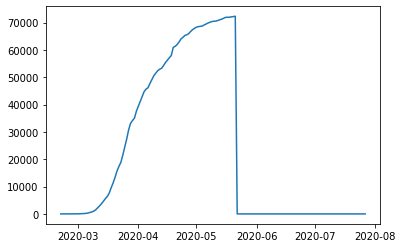

In [12]:
dates, ns, ds = usa.dfsanidad_cadata(df, 'MA')
plt.plot(dates, ns[0])

In [17]:
path  = '/Users/hernando/investigacion/bio/C19/data/'
ifile = 'datos_ccaas.csv'
df = pd.read_csv(path + ifile)

In [18]:
ccaa_ids = set(df.ccaa_iso)
print(ccaa_ids)

{'CM', 'MD', 'IB', 'CN', 'AS', 'CB', 'CE', 'GA', 'CL', 'PV', 'AN', 'AR', 'RI', 'ML', 'EX', 'MC', 'NC', 'CT', 'VC'}


In [20]:
df.head()

,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida
0,AN,2020-01-31,0,0,0,0,0
1,AR,2020-01-31,0,0,0,0,0
2,AS,2020-01-31,0,0,0,0,0
3,CB,2020-01-31,0,0,0,0,0
4,CE,2020-01-31,0,0,0,0,0


In [21]:
dfc = df[df.ccaa_iso == 'CT']

In [23]:
dates = dfc.fecha.values
type(dates[0])

str

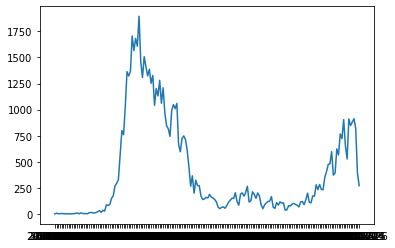

In [24]:
plt.plot(dfc.fecha, dfc.num_casos)

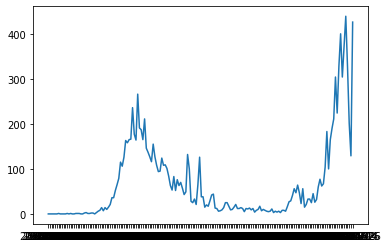

In [25]:
dfc = df[df.ccaa_iso == 'AR']
plt.plot(dfc.fecha, dfc.num_casos)

In [26]:
canames = ['Madrid', 'Castilla y Leon', 'Castilla La Mancha',
           'Cataluna', 'C. Valenciana', 'Aragon',
           'Pais Vasco', 'Navarra', 'La Rioja',
           'Cantabria', 'Asturias', 'Galicia',
           'Murcia', 'Andalucia', 'Extremadura',
           'Canarias', 'Baleares']

ccaa_id = {'Madrid'     : 'MD', 'Castilla y Leon' : 'CL', 'Castilla La Mancha' : 'CM',
           'Cataluna'   : 'CT', 'C. Valenciana'   : 'VC', 'Aragon'             : 'AR',
           'Pais Vasco' : 'PV', 'Navarra'         : 'NC', 'La Rioja'           : 'RI',
           'Cantabria'  : 'CB', 'Asturias'        : 'AS', 'Galicia'            : 'GA',
           'Murcia'     : 'MC', 'Andalucia'       : 'AN', 'Extremadura'        : 'EX',
           'Canarias'   : 'CN', 'Baleares'        : 'IB'}

times   = (5., 3., 5.)
dates_blind = None #('2020-03-5', '2020-03-25')
q0    = 5e-2

def ca_cases(caname, df = df):
    id  = ccaa_id[caname]
    dfc = df[df.ccaa_iso == id]
    dates, cases = dfc.fecha.values, dfc.num_casos.values
    dates = np.array([np.datetime64(xi) for xi in dates])
    return dates, cases, np.maximum(np.sqrt(cases), 2.4)
    
    
def plt_kfs_cases_ca(dates, cases, ucases, times, title = '',
                      dates_blind = None, q0 = 1., d0 = 0):

    if (not usp.has_figure()):
        plt.figure(figsize = (6, 5))
    d0               = np.timedelta64(d0, 'D')
    rs1, rs2 = us.useir_kfs_cases(dates, cases, ucases, times, 
                                  dates_blind = dates_blind, q0 = q0)
    plt.errorbar(dates, cases, yerr = ucases, 
                 ls = '', marker = 'o', color = 'black', ms = 6);
    usp.formatter(plt.gca()); plt.title(title); plt.ylabel('cases')
    plt.yscale('log')
    ax2 = plt.gca().twinx()
    ax2.errorbar(dates - d0, rs1[0], yerr = rs1[1], 
                 ls = '--', marker = 'o', ms = 4, color = 'blue', label = r'$R$')
    ax2.grid(which = 'both'); plt.legend(); ax2.set_ylabel(r'$R$')
    ymax = min(np.max(rs1[0] + 0.5), 8)
    plt.ylim((0., ymax));


def plt_kfs_cases_ccaa(canames = canames, times = times, ca_cases = ca_cases,
                        dates_blind = dates_blind, q0 = q0, ncols = 3):

    nrows = int(len(canames)/ncols)
    if (len(canames)%ncols > 0): nrows += 1
    plt.figure(figsize = (ncols * 6, nrows * 5))
    ti, td, tm           = int(times[0]), int(times[1]), int(times[-1])
    for i, caname in enumerate(canames):
        dates, cases, ucases = ca_cases(caname)
        ax = plt.subplot(nrows, ncols, i + 1, axisbelow = True)
        plt_kfs_cases_ca(dates, cases, ucases, times, dates_blind = dates_blind, q0 = q0, 
                         d0 = ti, title = caname)        
    plt.tight_layout()
    

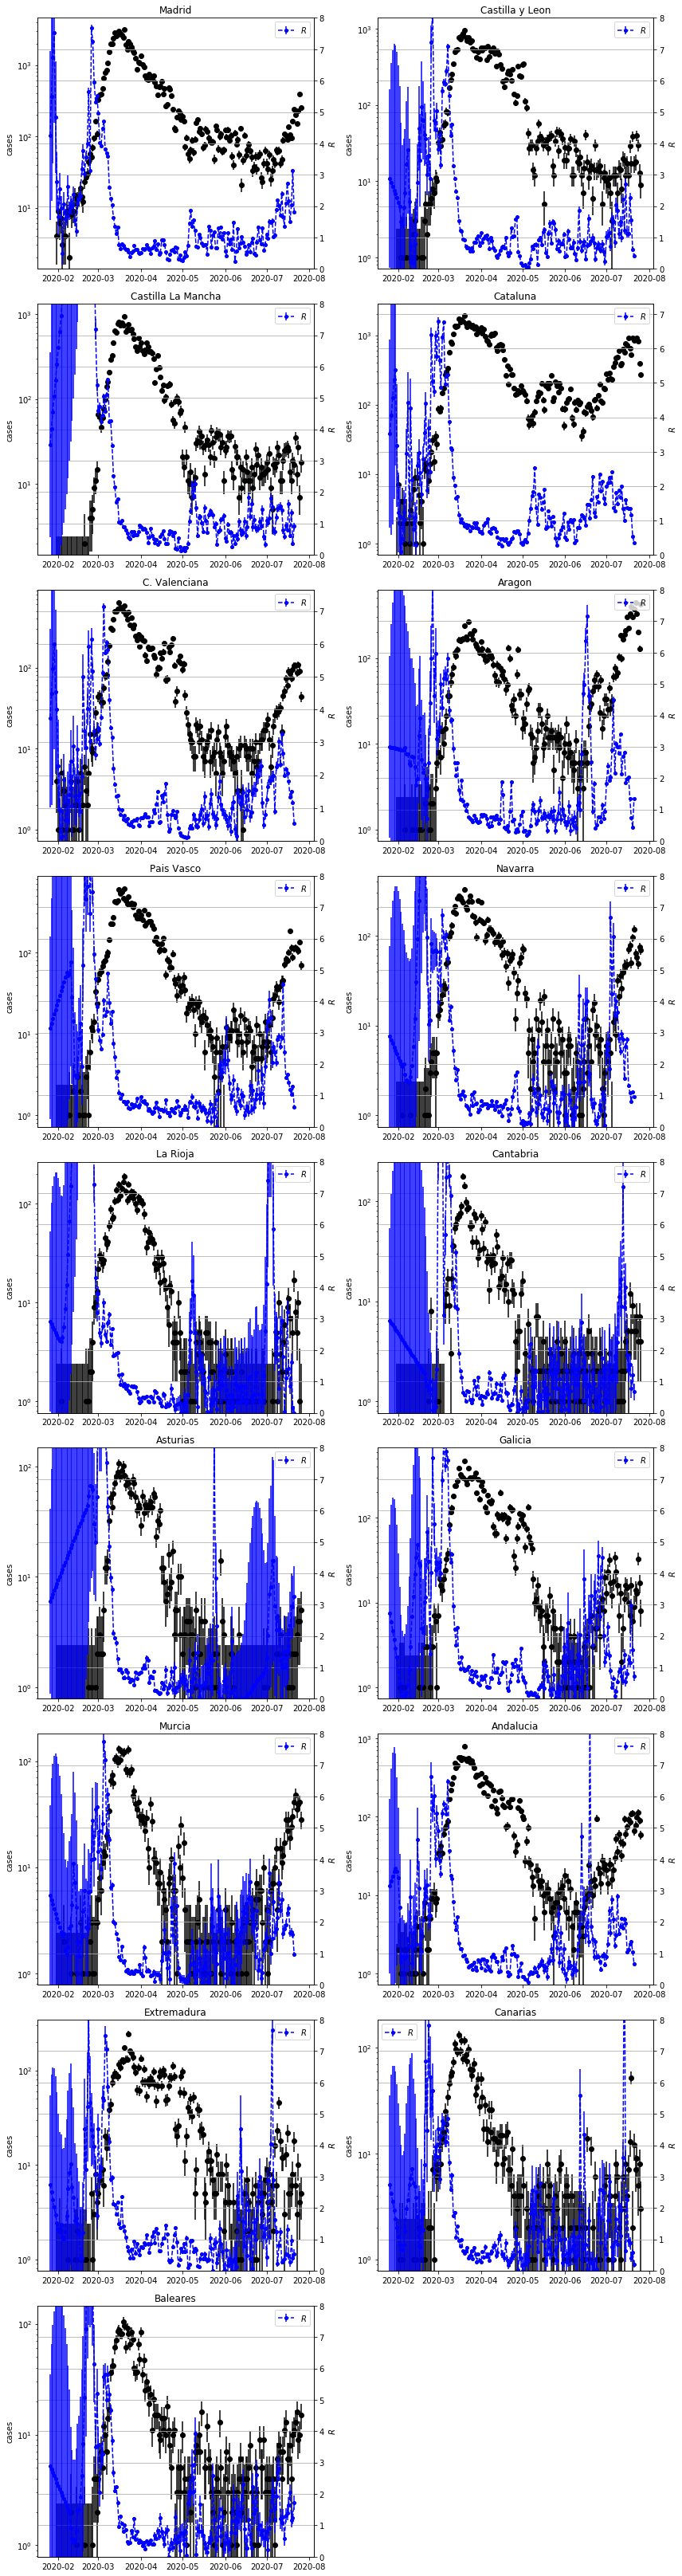

In [28]:
plt_kfs_cases_ccaa(ccaa_id.keys(), q0 = 1., ncols = 2)

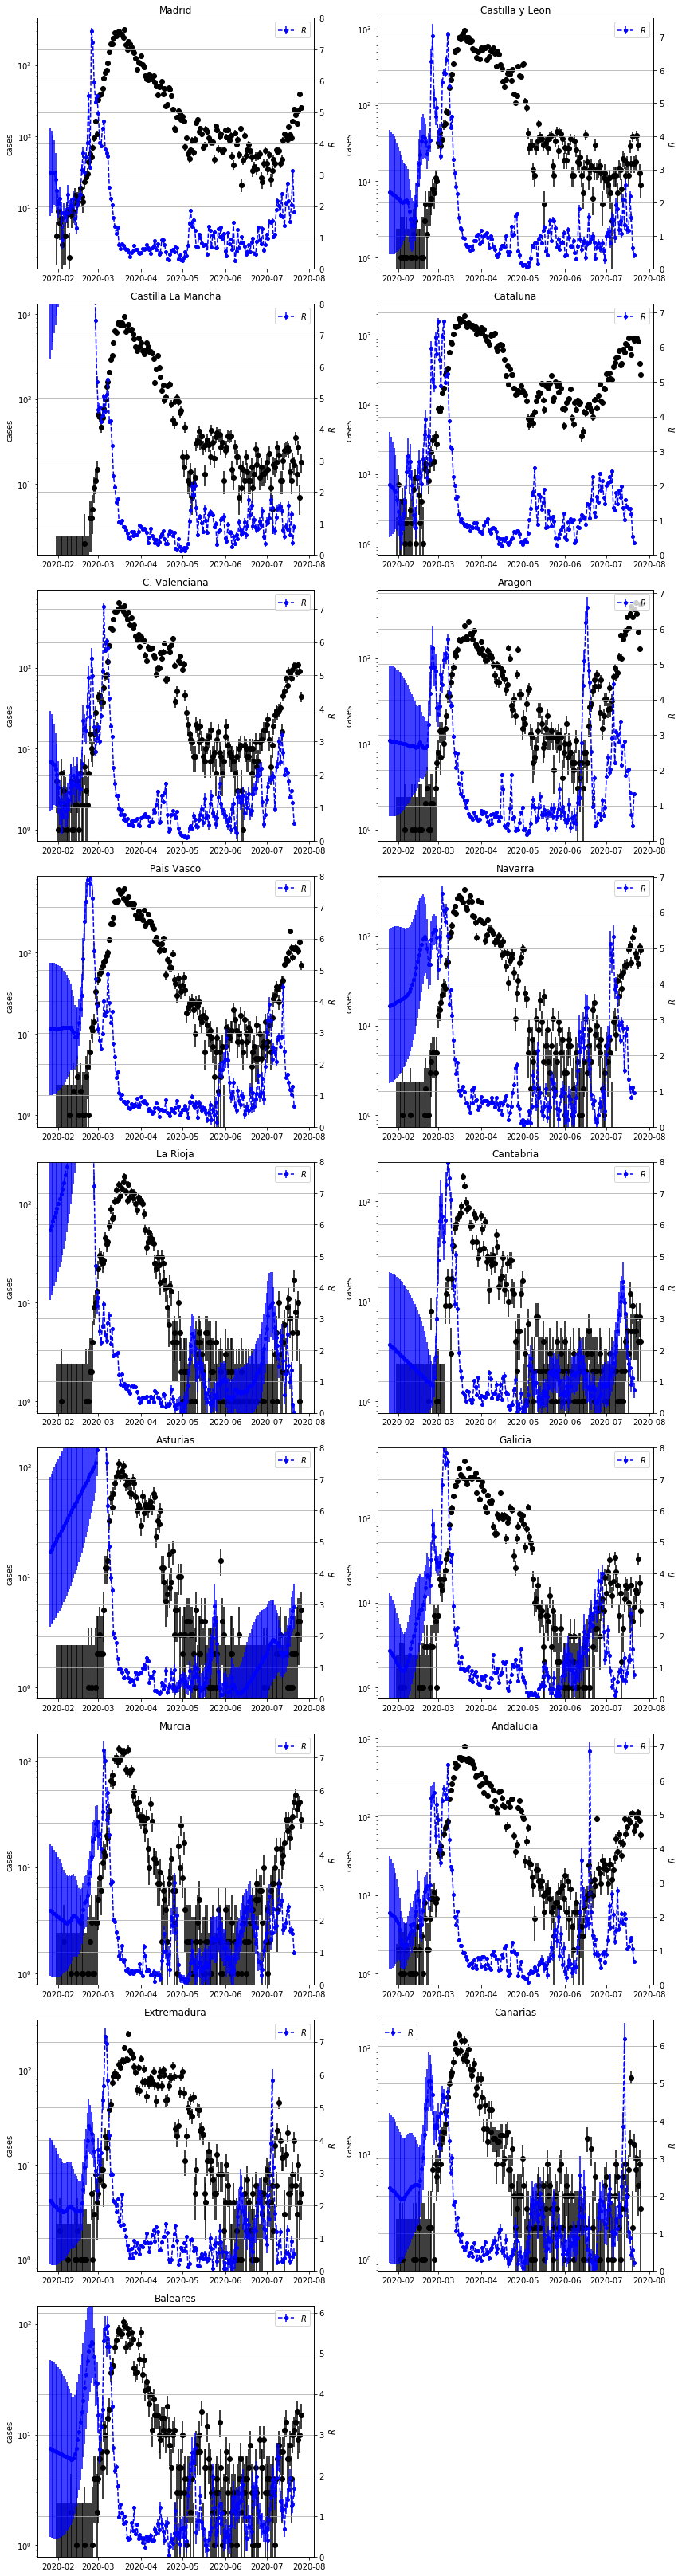

In [30]:
plt_kfs_cases_ccaa(ccaa_id.keys(), q0 = 5.e-2, ncols = 2)

In [138]:
dates, cases, ucases = ca_cases('Aragon')

In [140]:
ts = np.arange(len(dates))

171 171


In [ ]:
frho = us.frho

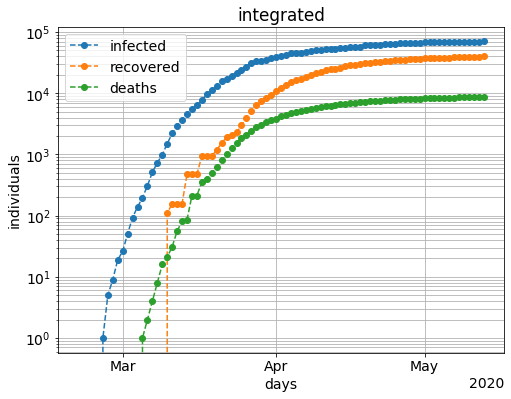

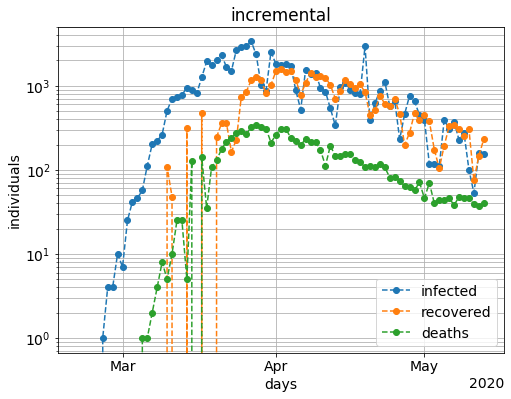

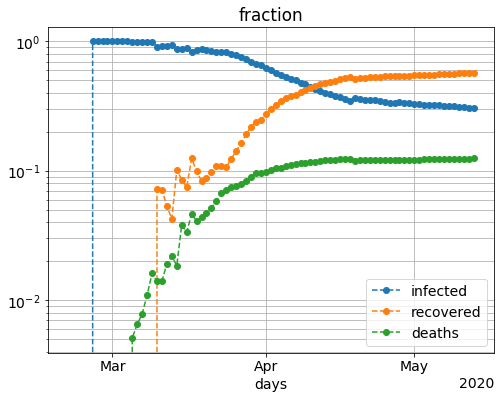

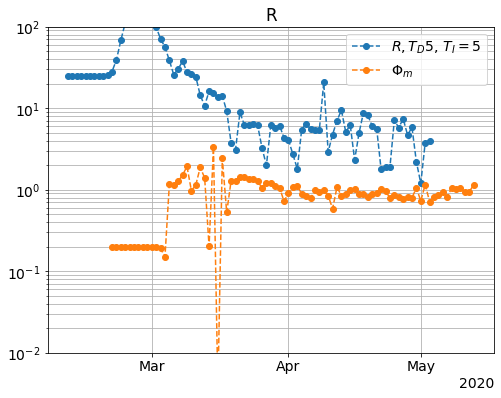

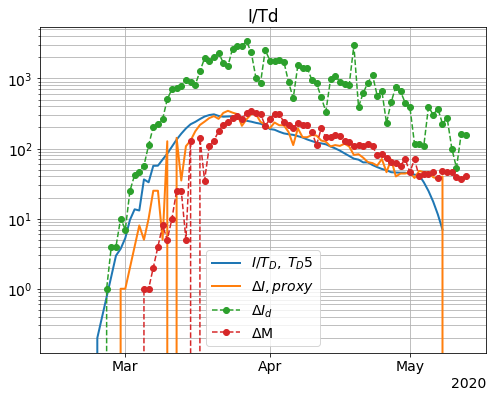

In [207]:
ca              = 'MA'
ti, tr, tm, td  = 5, 7, 7, 5
phim            = 1.
times           = (ti, tr, tm, td)
frho            = us.fpois

dates, ns, ds   = aus.data_ca(df, ca)
aus.plt_data_ca(dates, ns, ds, yscale = 'log');
kfres, nisres   = aus.ana_ca(dates, ns, ds, times, frho, phim)
aus.plt_ana_ca(dates, ds, kfres, nisres, times, yscale = 'log'); # 'linear'

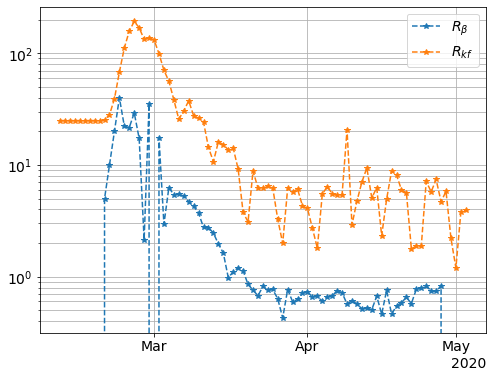

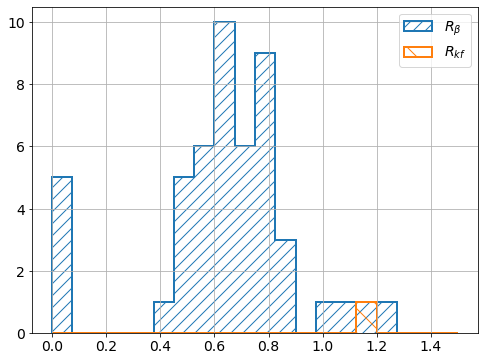

In [208]:
xts          = np.arange(len(dates))
xdios        = nisres[0]
xrhod, xrhoi = frho(td), frho(ti)

xs       = kfres[0]
betkf    = npa([xi[0] for xi in xs]) 
betas    = us.betas(xts, xdios, xrhod, xrhoi)

plt.figure(figsize = ((8, 6)))
plt.plot(dates - np.timedelta64(ti + td, 'D'), betas * td, ls = '--', marker = '*', label = r'$R_\beta$')
plt.plot(dates - np.timedelta64(ti + td, 'D'), betkf * td, ls = '--', marker = '*', label = r'$R_{kf}$')
aus.formatter(plt.gca()); plt.grid(which='both'); plt.legend(); plt.yscale('log'); 

plt.figure(figsize = (8, 6));
sel = dates >= aus.npdate('2020-03-15')
plt.hist(betas[sel] * td, 20, (0., 1.5), histtype='step', hatch = '//', lw = 2, label = r'$R_\beta$');
plt.hist(betkf[sel] * td, 20, (0., 1.5), histtype='step', hatch = '\\', lw = 2, label = r'$R_{kf}$');
plt.grid(); plt.legend();

### Scan with respect the paramters and pdfs

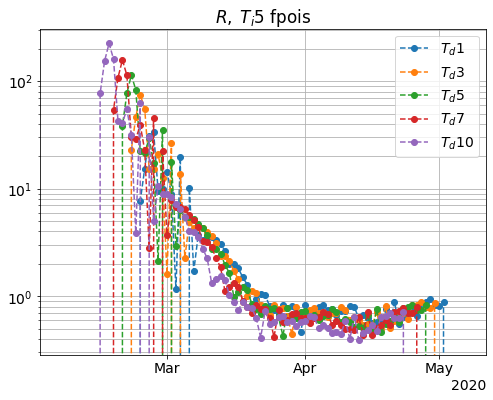

In [140]:
def scan_tds(xdios, ti, tds):
    plt.figure(figsize = (8, 6))
    for td in tds:
        betas = us.betas(xts, xdios, frho(td), frho(ti))
        xlabel = r'$T_d $'+str(td)
        plt.plot(dates - np.timedelta64(ti + td, 'D'), betas * td, ls = '--', marker = 'o', label = xlabel);
    xtitle = r'$R, \; T_i $' + str(ti)+' '+str(frho).split()[1]
    plt.title(xtitle); plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); aus.formatter(plt.gca());
    
ti    = 5
tds   = (1, 3, 5, 7, 10)
scan_tds(xdios, ti, tds)

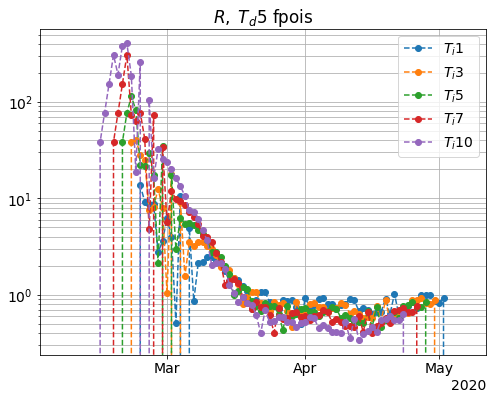

In [142]:
def scan_tis(xdios, td, tis):
    plt.figure(figsize = (8, 6))
    for ti in tis:
        betas = us.betas(xts, xdios, frho(td), frho(ti))
        xlabel = r'$T_i $'+str(ti)
        plt.plot(dates - np.timedelta64(ti+td, 'D'), betas * td, ls = '--', marker = 'o', label = xlabel);
    xtitle = r'$R, \; T_d $' + str(td)+' '+str(frho).split()[1]
    plt.title(xtitle); plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); aus.formatter(plt.gca());
    
td    = 5
tis   = (1, 3, 5, 7, 10)
scan_tis(xdios, td, tis)

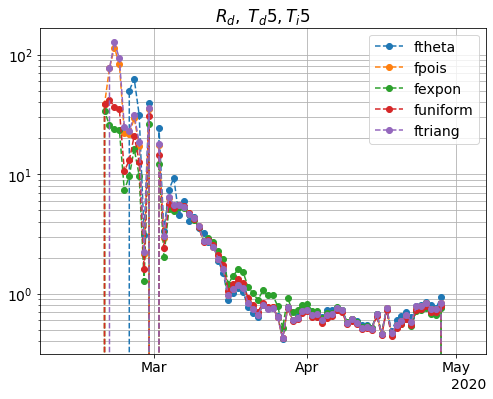

In [143]:
def scan_rhos(xdios, td, ti, rhos):
    plt.figure(figsize = (8, 6))
    for rho in rhos:
        betas = us.betas(xts, xdios, rho(td), rho(ti))
        xlabel = str(rho).split()[1]
        plt.plot(dates - np.timedelta64(ti + td, 'D'), betas * td, ls = '--', marker = 'o', label = xlabel);
    xtitle = r'$R_d, \; T_d $' + str(td)+'$, T_i$'+str(ti)
    plt.title(xtitle); plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); aus.formatter(plt.gca());
    
td, ti    = 5, 5
rhos  = (us.ftheta, us.fpois, us.fexpon, us.funiform, us.ftriang)
scan_rhos(xdios, td, ti, rhos);

### Replace Proxy: death and detected

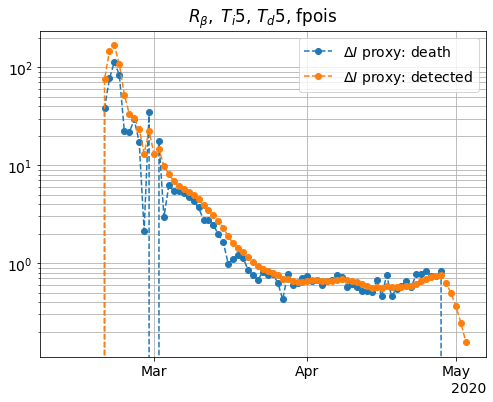

In [148]:
ca              = 'AR'
ti, tr, tm, td  = 5, 7, 7, 5
phim            = 0.10 
times           = (ti, tr, tm, td)
frho            = us.fpois

dates, ns, ds   = aus.data_ca(df, ca)
#aus.plt_data_ca(dates, ns, ds, yscale = 'log');
kfres0, nisres0   = aus.ana_ca(dates, ns, ds, times, frho, phim)
kfres1, nisres1   = aus.ana_ca(dates, ns, ds, times, frho, 0.)

xdios1 = nisres[0]
xdios2 = nisres[1]

xts          = np.arange(len(dates))
xrhod, xrhoi = frho(td), frho(ti)

betas0 = us.betas(xts, xdios1, xrhod, xrhoi)
betas1 = us.betas(xts, xdios2, xrhod, xrhoi)

xdates = dates - np.timedelta64(ti + td, 'D')
plt.figure(figsize = (8, 6))
plt.plot(xdates, betas0 * td, ls = '--', marker = 'o', label = r'$\Delta I$ proxy: death')
plt.plot(xdates, betas1 * td, ls = '--', marker = 'o', label = r'$\Delta I$ proxy: detected')
plt.title(r'$R_\beta, \; T_i$'+str(ti)+r', $T_d$'+str(td)+', '+str(frho).split()[1])
plt.grid(which = 'both'); plt.legend(); plt.yscale('log'); aus.formatter(plt.gca());

## Compare between spanish regions

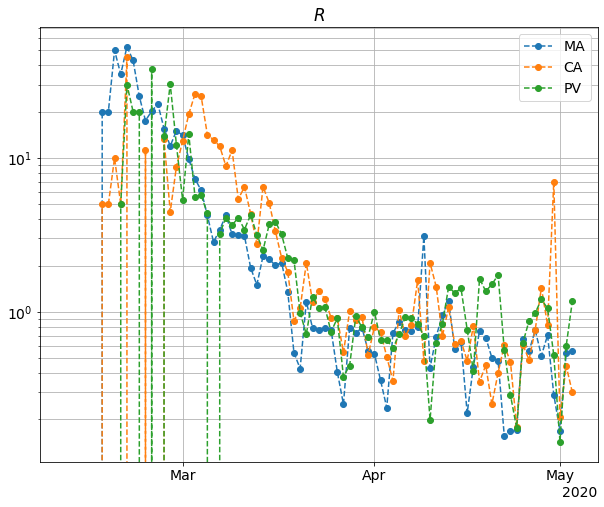

In [197]:
cas = ['MA', 'CA', 'PV']
betas = []
for ca in cas:
    #print(ca)
    dates, ns, ds   = aus.data_ca(df, ca)
    #aus.plt_data_ca(dates, ns, ds, yscale = 'log');
    #kfres0, nisres0   = aus.ana_ca(dates, ns, ds, times, frho, phim)
    kfres, nisres   = aus.ana_ca(dates, ns, ds, times, frho, 0.)
    xdios = nisres[0]
    beta = us.betas(xts, xdios, xrhod, xrhoi)
    betas.append(beta)
xdates = dates - np.timedelta64(ti + td, 'D')

plt.figure(figsize = (10, 8))
for i in range(len(cas)):
    plt.plot(xdates, td * betas[i], ls = '--', marker = 'o', label = cas[i])
plt.title(r'$R$')
aus.formatter(plt.gca()); plt.grid(which = 'both'); plt.legend(); plt.yscale('log');

### Extrapolation

ftheta


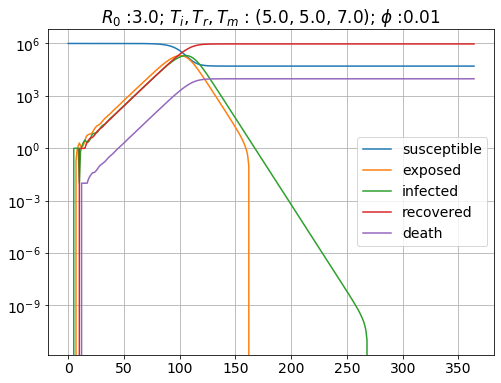

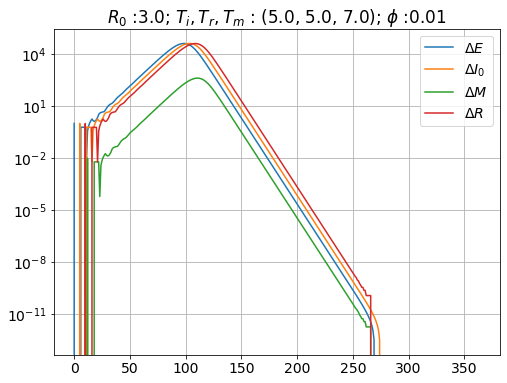

In [189]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 7.
PhiM            = 0.01
ndays           = 365
rho             = 'poisson'
frho            = us.frho(rho)

#S0
#D0 

ts = np.arange(ndays)
SS, DD          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho, S0, D0)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

title = r'$R_0$ :'+ str(R0)+ r'; $T_i, T_r, T_m$ : '+str((TI, TR, TM)) + r'; $\phi$ :'+str(PhiM)
us.plt_uSEIR(ts, SS, DD, title)

## FoM

**rw** rate in a week average with a time-ifection delay.

In [61]:
def betaave(xdios, td, ti):
    nsize = len(xdios)
    nis = npa([np.sum(xdios[max(i - td - ti, 0) : i]) for i in range(nsize)])
    rs = xdios/np.maximum(1., nis)
    rs[nis <= 0] = 0
    return rs, nis

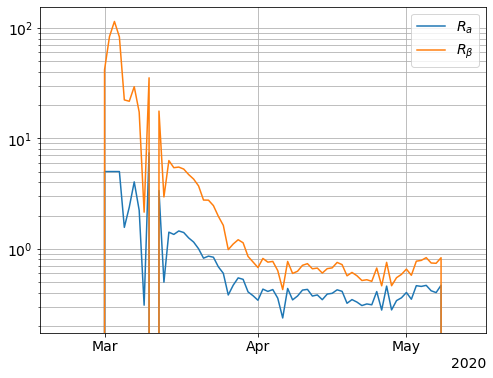

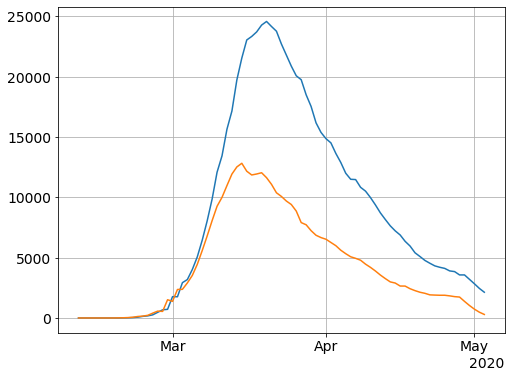

In [73]:
xtd, xti    = 5, 5
knis        = nisres[1]
betav, xnis = betaave(xdios, xtd, xti)

plt.figure(figsize = (8, 6))
#xdates = dates -  np.timedelta64(xtd + xti + 7, 'D')
plt.plot(dates, betav * td, label = r'$R_a$'); 
plt.plot(dates, betas * td, label = r'$R_\beta$'); 
plt.grid(which = 'both'); plt.yscale('log'); plt.legend();
aus.formatter(plt.gca());

plt.figure(figsize = (8, 6))
plt.plot(dates - np.timedelta64(ti + td, 'D'), xnis); 
plt.plot(dates - np.timedelta64(ti + td, 'D'), knis); 
aus.formatter(plt.gca()); plt.grid(which='both');